### Algorithm implemented :
The following algorithm would be implemented in this Unsupervised Anomaly Detection on the retail stores dataset  
* Cluster based anomaly detection (K-mean)
* Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
* Markov Chain
* Isolation Forest
* One class SVM
* RNN (comparison between prediction and reality)

In [1]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

### 1 Data
#### 1.1 Extract data
The dataset is the master retail dataset used in this project - master_dataset.xls


In [3]:
# load the master_dataset.xls
df = pd.read_excel('master_dataset.xlsx', sheetname='Sheet1')

#### 1.2 Understand data


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 95 columns):
Store                     8190 non-null int64
Date                      8190 non-null datetime64[ns]
Temperature               8190 non-null float64
Fuel_Price                8190 non-null float64
MarkDown1                 8190 non-null float64
MarkDown2                 8190 non-null float64
MarkDown3                 8190 non-null float64
MarkDown4                 8190 non-null float64
MarkDown5                 8190 non-null float64
CPI                       8190 non-null float64
Unemployment              8190 non-null float64
IsHoliday                 8190 non-null bool
Type                      8190 non-null object
Size                      8190 non-null int64
Jewelry                   8190 non-null float64
Pets                      8190 non-null float64
TV_Video                  8190 non-null float64
Cell_Phones               8190 non-null float64
Pharmaceutical            8190

In [5]:
# check the timestamp format and frequency
print(df['Date'].head(10))

0   2010-05-02
1   2010-12-02
2   2010-02-19
3   2010-02-26
4   2010-05-03
5   2010-12-03
6   2010-03-19
7   2010-03-26
8   2010-02-04
9   2010-09-04
Name: Date, dtype: datetime64[ns]


In [6]:
# check the markdowns mean
print(df['MarkDown1'].mean())
print(df['MarkDown2'].mean())
print(df['MarkDown3'].mean())
print(df['MarkDown4'].mean())
print(df['MarkDown5'].mean())

8887.617797313967
6107.224317460187
928.7852197802101
3130.1765555554607
4544.031686202577


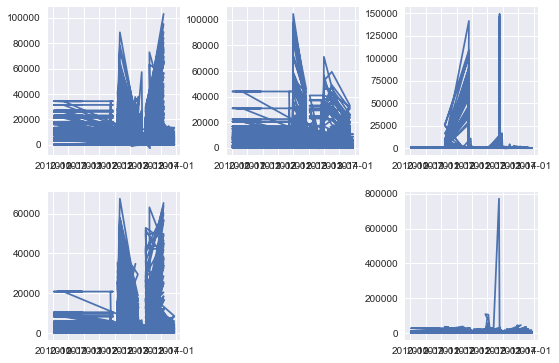

In [7]:
# change the type of timestamp column for plotting
# plot the markdown data

plt.subplot(231)
x = df['Date']
y = df['MarkDown1']
plt.plot(x, y)
ax1 = plt.subplot(231)

plt.subplot(232)
x = df['Date']
y = df['MarkDown2']
plt.plot(x, y)
ax2 = plt.subplot(232)

plt.subplot(233)
x = df['Date']
y = df['MarkDown3']
plt.plot(x, y)
ax3 = plt.subplot(233)

plt.subplot(234)
x = df['Date']
y = df['MarkDown4']
plt.plot(x, y)
ax4 = plt.subplot(234)

plt.subplot(236)
x = df['Date']
y = df['MarkDown5']
plt.plot(x, y)
ax5 = plt.subplot(236)

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show() 



#### 1.3 Feature engineering
Extracting some useful features

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['Date'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [9]:
# time with int to plot easily
df['time_epoch'] = (df['Date'].astype(np.int64)/100000000000).astype(np.int64)

##### 1.3.1 MarkDown1 by Store Type

In [10]:
# creation of 3 distinct categories that seem useful (Store Type A, Store type B and Store Type C)
df['categories'] = df['Type']
a = df.loc[df['categories'] == 'A', 'MarkDown1']
b = df.loc[df['categories'] == 'B', 'MarkDown1']
c = df.loc[df['categories'] == 'C', 'MarkDown1']

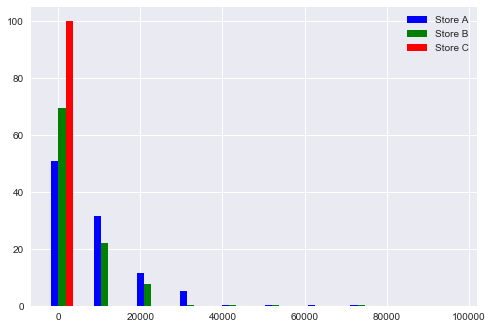

In [11]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Store A')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Store B')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Store C')

plt.legend()
plt.show()

##### 1.3.2 MarkDown2 by Store Type

In [12]:
# creation of 3 distinct categories that seem useful (Store Type A, Store type B and Store Type C)
df['categories'] = df['Type']
a = df.loc[df['categories'] == 'A', 'MarkDown2']
b = df.loc[df['categories'] == 'B', 'MarkDown2']
c = df.loc[df['categories'] == 'C', 'MarkDown2']

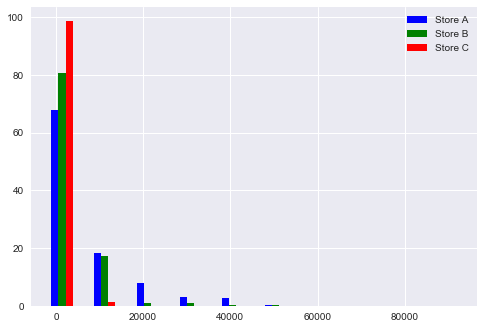

In [13]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Store A')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Store B')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Store C')

plt.legend()
plt.show()

##### 1.3.3 MarkDown3 by Store Type

In [14]:
# creation of 3 distinct categories that seem useful (Store Type A, Store type B and Store Type C)
df['categories'] = df['Type']
a = df.loc[df['categories'] == 'A', 'MarkDown3']
b = df.loc[df['categories'] == 'B', 'MarkDown3']
c = df.loc[df['categories'] == 'C', 'MarkDown3']

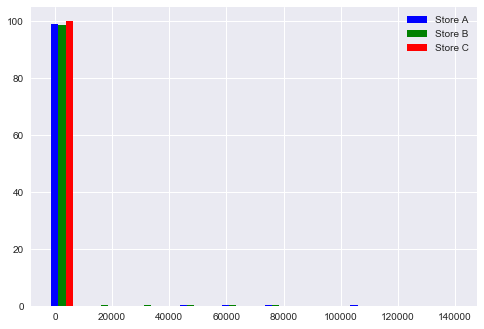

In [15]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Store A')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Store B')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Store C')

plt.legend()
plt.show()

#### 1.3.4 MarkDown4 by Store Type

In [16]:
# creation of 3 distinct categories that seem useful (Store Type A, Store type B and Store Type C)
df['categories'] = df['Type']
a = df.loc[df['categories'] == 'A', 'MarkDown4']
b = df.loc[df['categories'] == 'B', 'MarkDown4']
c = df.loc[df['categories'] == 'C', 'MarkDown4']

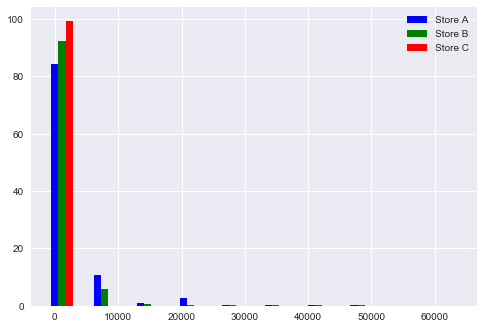

In [17]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Store A')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Store B')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Store C')

plt.legend()
plt.show()

#### 1.3.5 MarkDown4 by Store Type

In [18]:
# creation of 3 distinct categories that seem useful (Store Type A, Store type B and Store Type C)
df['categories'] = df['Type']
a = df.loc[df['categories'] == 'A', 'MarkDown5']
b = df.loc[df['categories'] == 'B', 'MarkDown5']
c = df.loc[df['categories'] == 'C', 'MarkDown5']

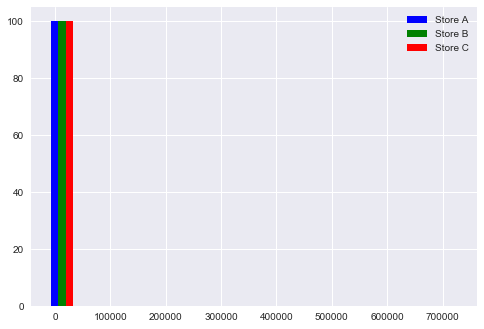

In [19]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Store A')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Store B')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Store C')

plt.legend()
plt.show()

We could see that store type C did not record reasonable sales during the Markdowns and Markdown 5 is likely to have a significant outlier.

### 2 Models
#### 2.1 Cluster only¶

Use for collective anomalies (unordered).
We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [20]:
# Store Sales
df['StoreTypeA_Bin'] = np.where(df['Type']=='A', 1, 0)
df['StoreTypeB_Bin'] = np.where(df['Type']=='B', 1, 0)
df['StoreTypeC_Bin'] = np.where(df['Type']=='C', 1, 0)

In [21]:
# Markdowns for Store A
df['StoreTypeAMk1'] = df.StoreTypeA_Bin * df.MarkDown1
df['StoreTypeAMk2'] = df.StoreTypeA_Bin * df.MarkDown2
df['StoreTypeAMk3'] = df.StoreTypeA_Bin * df.MarkDown3
df['StoreTypeAMk4'] = df.StoreTypeA_Bin * df.MarkDown4
df['StoreTypeAMk5'] = df.StoreTypeA_Bin * df.MarkDown5

In [22]:
# Markdowns for Store A
df['StoreTypeBMk1'] = df.StoreTypeA_Bin * df.MarkDown1
df['StoreTypeBMk2'] = df.StoreTypeA_Bin * df.MarkDown2
df['StoreTypeBMk3'] = df.StoreTypeA_Bin * df.MarkDown3
df['StoreTypeBMk4'] = df.StoreTypeA_Bin * df.MarkDown4
df['StoreTypeBMk5'] = df.StoreTypeA_Bin * df.MarkDown5

In [23]:
# Markdowns for Store A
df['StoreTypeCMk1'] = df.StoreTypeA_Bin * df.MarkDown1
df['StoreTypeCMk2'] = df.StoreTypeA_Bin * df.MarkDown2
df['StoreTypeCMk3'] = df.StoreTypeA_Bin * df.MarkDown3
df['StoreTypeCMk4'] = df.StoreTypeA_Bin * df.MarkDown4
df['StoreTypeCMk5'] = df.StoreTypeA_Bin * df.MarkDown5

In [24]:
# Take useful feature and standardize them
data = df[['StoreTypeAMk1', 'StoreTypeAMk2', 'StoreTypeAMk3', 'StoreTypeAMk4','StoreTypeAMk5',
          'StoreTypeBMk1', 'StoreTypeBMk2', 'StoreTypeBMk3', 'StoreTypeBMk4','StoreTypeBMk5',
          'StoreTypeCMk1', 'StoreTypeCMk2', 'StoreTypeCMk3', 'StoreTypeCMk4','StoreTypeCMk5']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

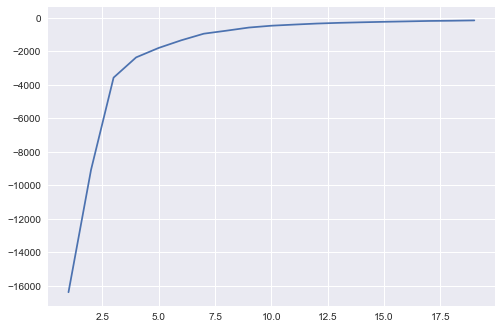

In [25]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [26]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     4652
7      992
4      922
2      823
3      327
11     253
14     140
12      25
6       13
1       13
10       9
13       9
5        9
8        2
9        1
Name: cluster, dtype: int64

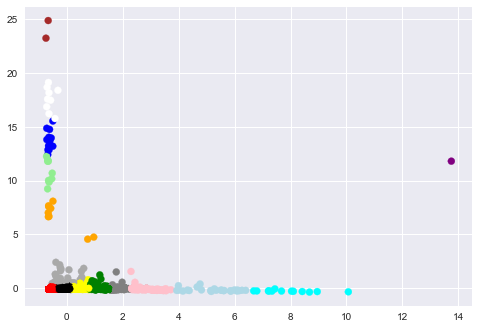

In [27]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [28]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

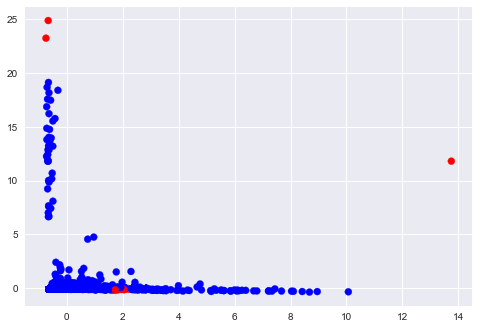

In [29]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

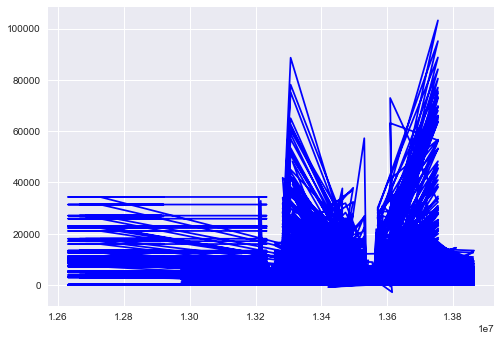

In [30]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df["anomaly21"] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['MarkDown1'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

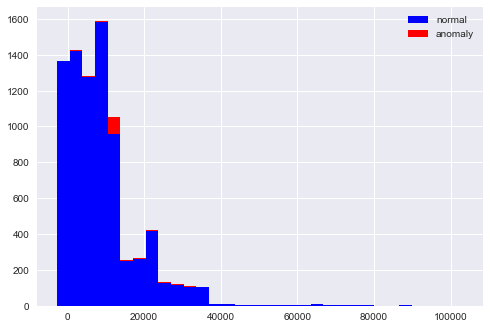

In [36]:
# visualisation of anomaly with MarkDown1 repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'MarkDown1']
b = df.loc[df['anomaly21'] == 1, 'MarkDown1']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

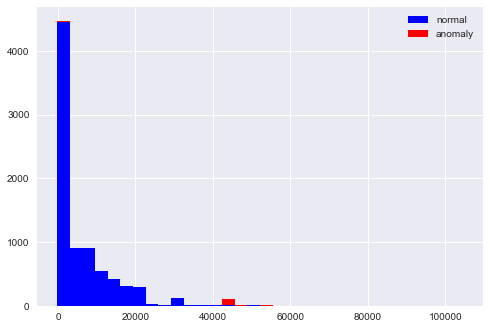

In [37]:
# visualisation of anomaly with MarkDown2 repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'MarkDown2']
b = df.loc[df['anomaly21'] == 1, 'MarkDown2']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

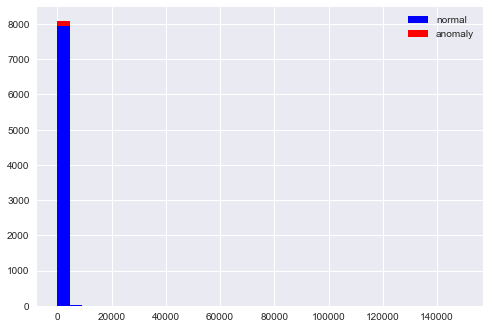

In [38]:
# visualisation of anomaly with MarkDown3 repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'MarkDown3']
b = df.loc[df['anomaly21'] == 1, 'MarkDown3']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

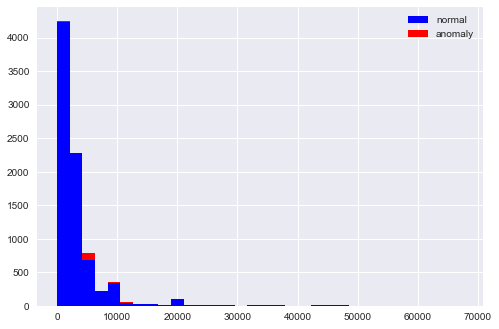

In [40]:
# visualisation of anomaly with MarkDown4 repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'MarkDown4']
b = df.loc[df['anomaly21'] == 1, 'MarkDown4']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

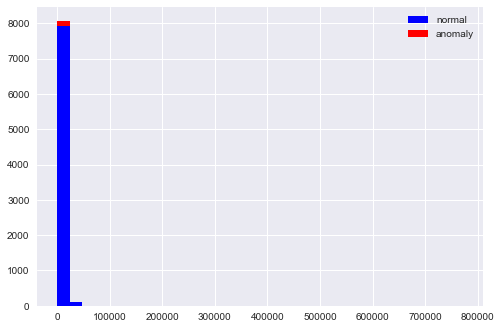

In [41]:
# visualisation of anomaly with MarkDown5 repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'MarkDown5']
b = df.loc[df['anomaly21'] == 1, 'MarkDown5']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low MarkDowns around the end of record as unusually low. It doesn't detect the highest MarkDowns.

#### 2.2 Categories + Gaussian
##### Use for contextual data and collective anomalies (unordered).
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.

In [43]:
# creation of 3 differents data set based on categories defined before. For MarkDown1
df['categories'] = df['Type']
df_class0  = df.loc[df['categories'] == 'A', 'MarkDown1']
df_class1  = df.loc[df['categories'] == 'B', 'MarkDown1']
df_class2  = df.loc[df['categories'] == 'C', 'MarkDown1']

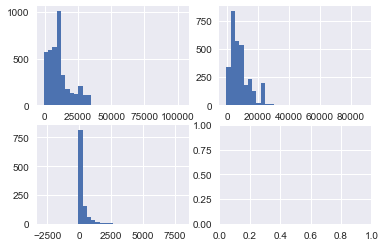

In [49]:
# plot MarkDown1 repartition by categories
%matplotlib inline  
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)

In [57]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
envelope.decision_function(X_train)



array([  570.04657316,  1042.83327312,  1043.17180492, ...,   980.32963328,
        1043.3176133 ,  1043.17180492])